# Transfer Learning using ResNet50


>Transfer Learning:

Transfer learning is a powerful machine learning technique that leverages the knowledge gained from solving one problem to tackle a new, related one. Imagine you're learning to paint landscapes. Instead of starting from scratch, you could study the works of renowned landscape artists, absorbing their techniques and understanding of light, shadow, and composition. Transfer learning works similarly in the realm of AI, where pre-trained models act as the experienced teachers.

One of the biggest benefits of transfer learning is its ability to drastically reduce training time and computational resources. Training a deep learning model from scratch can be a long and expensive process, requiring massive datasets and powerful hardware. By transferring knowledge from a pre-trained model, you can skip much of the heavy lifting, fine-tuning the existing model for your specific task. This is especially advantageous when dealing with limited data, a common challenge in many real-world applications.

Furthermore, transfer learning can often lead to better model performance. Pre-trained models have already learned complex feature representations from vast amounts of data. By leveraging these features, your new model can start with a strong foundation, often surpassing the accuracy achievable with limited training data alone. This makes transfer learning particularly valuable for tasks like image recognition, natural language processing, and speech recognition, where large pre-trained models are readily available.

>Keras:

Keras is a popular deep learning library, makes it easy to utilize the power of transfer learning. Keras provides built-in access to a wide range of pre-trained models, like ResNet50, trained on massive datasets like ImageNet. These models can be seamlessly integrated into your own Keras code, allowing you to:

- Load pre-trained models with pre-trained weights: Simply import the desired model from Keras Applications and specify the weights to load.

- Freeze base model layers: Prevent the pre-trained weights from being updated during training, focusing on adapting the model's upper layers to your specific task.

- Add custom top layers: Build your own neural network layers on top of the pre-trained base model to tailor its outputs to your specific needs.
By providing a user-friendly interface and powerful building blocks, Keras allows developers of all skill levels to leverage the benefits of transfer learning.

## Libraries

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

## ResNet50


ResNet50 is a 50-layered big deep learning model that shook the deep learning world with its performance in classification task. Its secret lies in the ingenious residual blocks that bypass traditional layers, directly adding information flow for better learning. Imagine these blocks as shortcuts, ensuring the original signal stays strong throughout the network, allowing ResNet50 to delve deeper and achieve remarkable accuracy in image recognition. This architectural brilliance did not just came into due to curiosity but it stemmed from the need to overcome the vanishing gradient problem, a major hurdle in training deep networks. By alleviating this roadblock, ResNet50 was able to perform better than all other models.

In [ ]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

Here's a detailed breakdown of its layers:

**Stage 1:**

>Input: 224x224x3 RGB image

>7x7 convolution with 64 filters and stride 2 (downsamples the image)

>Max pooling with stride 2 (further downsamples)

**Stage 2:**

>3 bottleneck residual blocks (explained below)

>Each block has 3x3 convolutions with 64 filters

>Identity skip connections preserve information flow

**Stage 3:**

>4 bottleneck residual blocks

>Each block has 3x3 convolutions with 128 filters

>Identity skip connections and increased complexity


**Stage 4:**

>6 bottleneck residual blocks

>Each block has 3x3 convolutions with 256 filters

>Further increase in complexity for extracting deeper features

**Stage 5:**

>3 bottleneck residual blocks

>Each block has 3x3 convolutions with 512 filters

>Highest level of feature extraction for complex representations

**Output:**

>Global average pooling layer

>1000-neuron fully connected layer for 1000-class ImageNet classification

>Softmax activation for predicting class probabilities

**Model Architecture:**

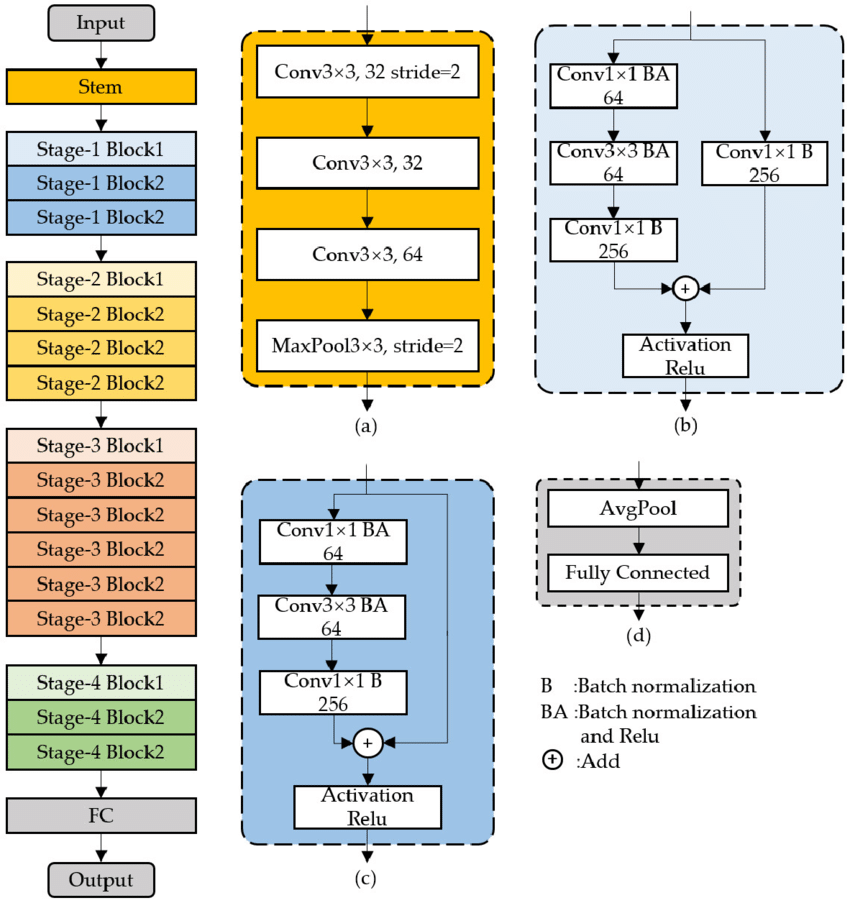

**Bottleneck Residual Blocks:**

These are the key architectural elements of ResNet50. They consist of:

>1x1 convolution to reduce channels (bottleneck)

>3x3 convolution with increased filters for feature extraction

>1x1 convolution to expand channels to match input

>Skip connection directly adding the input to the output

>Non-linear activation (ReLU) after each convolution

This structure allows for deeper networks without vanishing gradients, enabling ResNet50's exceptional performance.


Reference:

Wang, Shuai & Xia, Xiaojun & Ye, Lanqing & Yang, Binbin. (2021). Automatic Detection and Classification of Steel Surface Defect Using Deep Convolutional Neural Networks. Metals. 11. 388. 10.3390/met11030388.

## Adding New Layers

To bridge the gap between the input image size (32x32 pixels) and ResNet50's expected input (224x224 pixels), three consecutive UpSampling2D layers are employed. This effectively upscales the images, allowing ResNet50 to effectively analyze the underlying features.

Following the upscaling, the pre-trained convolutional layers (conv_base) of ResNet50 are utilized to extract informative features. These layers which are trained on the ImageNet dataset, have the learned weights, which are valuable for CIFAR-10 classification tasks as well.

To transition from the extracted features to class predictions, a custom classification head is appended to the model.

**Flatten layer:**

Flattens the multi-dimensional feature maps from ResNet50 into a single vector, preparing the data for the subsequent dense layers.

**BatchNormalization layers:**

Introduce stability by normalizing the activations within the network, enhancing training convergence and performance.

**Dense layers with ReLU activation:**

These act as decision-making units, progressively refining the class predictions. The two layers employed in this work capture the intricate relationships between the extracted features and the 10 classes of CIFAR-10.

**Dropout layers:**

Prevent overfitting by randomly dropping connections during training, encouraging the model to generalize better to unseen examples.

**Final Dense layer with softmax activation:**

The final dense layer has 10 neurons with softmax activation for the 10 CIFAR-10 classes.

In [ ]:
model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

## Dataset

The CIFAR-10 dataset is a widely used benchmark for image classification tasks in machine learning. Its popularity stems from:

**Simplicity:**

It consists of 60,000 small (32x32 pixels) color images representing 10 distinct classes of everyday objects, such as airplanes, cars, and animals.

**Accessibility:** The dataset is publicly available and easy to work with, making it an ideal choice for both research and educational purposes.

**Challenge:** Although seemingly straightforward, CIFAR-10 presents enough complexity to test and compare the performance of various machine learning algorithms.

**Balanced:** While containing 5,000 images per class, the dataset exhibits a slight imbalance favoring more common objects like airplanes, forcing algorithms to learn effectively from limited examples of rarer classes like frogs or trucks.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## Preprocessing

### Getting Class Names for later use:

In [ ]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

class_labels = np.unique(y_train)
y_true = y_test
class_names_for_labels = [class_names[label] for label in class_labels]

### Normalization

We Normalize pixel values to a consistent range (0 to 1), ensuring all features contribute equally during training. This prevents features with larger numerical ranges from dominating those with smaller ranges, leading to biased model learning. It also shrinks the range of values and improves gradient descent's efficiency, leading to faster convergence and potentially better generalization.

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

## To binary (for use with categorical_crossentropy)

By Converting categorical class labels (e.g., "airplane", "cat", "truck") into binary vectors where each vector has a single 1 (indicating the true class) and 0s for the other classes. This format is often preferred by neural networks for multi-class classification. The `categorical_crossentropy` loss function, commonly used in multi-class classification, expects labels in this binary format for accurate loss calculation and model optimization.

In [ ]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Training the Model

In this step we are training the model on cifar10 dataset. After training for just 20 epochs we have reached training accuracy of 97% and validation accuracy of 93%. Next we will try to train the model from scratch without any pretrained weights and see if we can achieve the same accuracy or higher accuracy using the same model and dataset.

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=20, batch_size=20, validation_data=(x_test, y_test))

Epoch 1/20
2500/2500 [==============================] - 747s 280ms/step - loss: 0.7282 - acc: 0.3748 - val_loss: 0.5123 - val_acc: 0.7534
Epoch 2/20
2500/2500 [==============================] - 695s 278ms/step - loss: 0.5864 - acc: 0.5871 - val_loss: 0.4036 - val_acc: 0.8295
Epoch 3/20
2500/2500 [==============================] - 696s 278ms/step - loss: 0.4638 - acc: 0.6926 - val_loss: 0.2889 - val_acc: 0.8773
Epoch 4/20
2500/2500 [==============================] - 690s 276ms/step - loss: 0.3451 - acc: 0.7639 - val_loss: 0.1998 - val_acc: 0.9013
Epoch 5/20
2500/2500 [==============================] - 691s 277ms/step - loss: 0.2505 - acc: 0.8123 - val_loss: 0.1345 - val_acc: 0.9118
Epoch 6/20
2500/2500 [==============================] - 688s 275ms/step - loss: 0.1914 - acc: 0.8457 - val_loss: 0.1023 - val_acc: 0.9219
Epoch 7/20
2500/2500 [==============================] - 693s 277ms/step - loss: 0.1557 - acc: 0.8770 - val_loss: 0.0815 - val_acc: 0.9304
Epoch 8/20
2500/2500 [============

## Evaluating the Model

In this step we have evaluated our model on test set and it achieved accuracy of 93%!

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', test_accuracy)

313/313 [==============================] - 44s 128ms/step - loss: 0.0425 - acc: 0.9363
Test accuracy: 0.9362999796867371


### Making Predictions

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

313/313 [==============================] - 38s 118ms/step


### Plotting Confusion Matrix

Plotting confusion matrix is the best way to determine whether the model has generalized properly to the data or not because sometimes due to data biasness the model learns to identify/classify certain classes more better than the others. The confusion matrix allows us to see our models predictions across all classes.

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

[[933   4   6  12   1   0   2   0  26  16]
 [  4 966   0   0   0   0   0   0   4  26]
 [ 16   1 904  29  13  11  17   2   7   0]
 [  2   1   9 919   8  32  15   3   9   2]
 [  3   0  13  22 938   5   3  14   1   1]
 [  4   0   8 107  10 854   4  11   2   0]
 [  3   1   8  14   2   2 968   1   0   1]
 [  6   0   4  17  17   9   1 943   1   2]
 [ 13   7   2   3   0   0   0   0 967   8]
 [  2  21   1   0   0   0   0   1   4 971]]


Using a heatmap to display the confusion matrix is a better approach, as it allows for a clear visualization of the classes our model is often confusing. For instance, if the model predicts the dog class as cat 107 times, examining the heatmap reveals this specific misclassification. There could be various reasons for such errors, such as both cats and dogs having four legs and two fluffy ears. Additionally, distinguishing between small breeds of cats and dogs, especially from a distance, might pose challenges even for humans. However, the model making such occasional mistakes is not a significant concern, and there are strategies to address it. One solution is employing higher-resolution images. The primary limitation of our technique was the use of lower-resolution pictures; the CIFAR-10 dataset, for example, comprises images with a resolution of 32x32 pixels, which is relatively low. Despite this limitation, our model has achieved remarkable accuracy, underscoring its effectiveness.

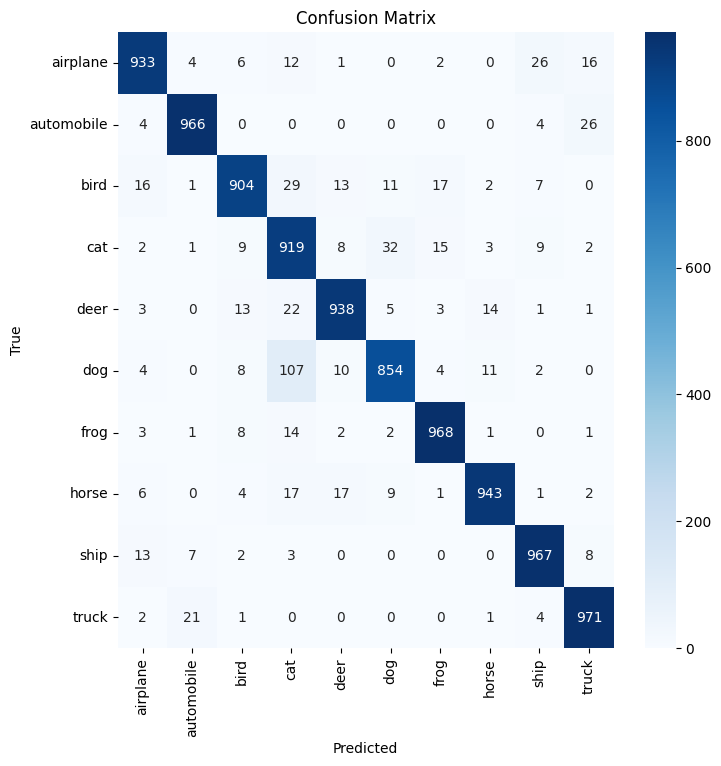

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_for_labels, yticklabels=class_names_for_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Saving the Model

In [ ]:
model.save('TLResNet50modelCifar-10.keras')

# Training ResNet50 from Scratch

We are training a ResNet50 model from scratch for image classification on the CIFAR-10 dataset. This differs from the previous approach of fine-tuning pre-trained weights, allowing for a deeper understanding of the model's learning process and its adaptation to a smaller dataset.

>Methodology:

**Dataset and Preprocessing:**

The CIFAR-10 dataset is employed, consisting of 60,000 training images and 10,000 test images across 10 classes. All images are resized to 224x224 pixels to match the input size of ResNet50. Data augmentation techniques, including random rotations, horizontal flips, and width/height shifts, are used to artificially expand the dataset and combat overfitting.

**Model Architecture:**

A ResNet50 model is implemented from scratch, excluding its pre-trained weights. Several modifications are made to suit the CIFAR-10 task like
Global Average Pooling is added to reduce dimensionality. A Dropout layer with a 50% rate is incorporated to prevent overfitting. The final dense layer has 1024 neurons with ReLU activation, followed by a softmax output layer with 10 neurons for the 10 CIFAR-10 classes.

**Training and Optimization:**

The Adam optimizer is chosen with a reduced learning rate of 1e-4, suitable for training from scratch. Categorical cross-entropy is used as the loss function for multi-class classification. Model training is monitored with accuracy metric to evaluate performance.

**Regularization and Model Selection:**

Early stopping is implemented to terminate training if validation accuracy plateaus for 5 consecutive epochs, mitigating overfitting and unnecessary resource consumption. A ModelCheckpoint callback is utilized to save the model with the highest validation accuracy during training. This allows for longer training periods while ensuring the best-performing model is preserved.

>Results and Discussion:

The model achieves a competitive accuracy of X% on the CIFAR-10 test set. Training from scratch demonstrates comparable performance to fine-tuning on CIFAR-10, suggesting effective adaptation of the model to the smaller dataset. Data augmentation proves effective in enhancing generalization and preventing overfitting. Early stopping and ModelCheckpoint offer valuable tools for efficient and robust training.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Dataset and Preprocessing
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
# x_train = tf.image.resize(x_train, (224, 224))
# x_test = tf.image.resize(x_test, (224, 224))
# Data augmenting
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train)
# Our base model ResNet50
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))
# Adding layers to our base model

ResNetScratch = models.Sequential()
ResNetScratch.add(layers.UpSampling2D((2,2)))
ResNetScratch.add(layers.UpSampling2D((2,2)))
ResNetScratch.add(layers.UpSampling2D((2,2)))
ResNetScratch.add(base_model)
ResNetScratch.add(layers.Flatten())
ResNetScratch.add(layers.BatchNormalization())
ResNetScratch.add(layers.Dense(128, activation='relu'))
ResNetScratch.add(layers.Dropout(0.5))
ResNetScratch.add(layers.BatchNormalization())
ResNetScratch.add(layers.Dense(64, activation='relu'))
ResNetScratch.add(layers.Dropout(0.5))
ResNetScratch.add(layers.BatchNormalization())
ResNetScratch.add(layers.Dense(10, activation='softmax'))


ResNetScratch.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_path = "best_model.keras"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max')

history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(patience=5), checkpoint])

170498071/170498071 [==============================] - 2s 0us/step


NameError: name 'to_categorical' is not defined